# Project submission: DEEP LEARNING_Implementation Image Classification
# Student: Ginju Soumya

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [11:47, 241kB/s]                                


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [4]:
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

In [5]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}. {} is out of range.'.format(len(features), batch_id, sample_id))
        return None
    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

In [6]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)
    pickle.dump((features, labels), open(filename, 'wb'))

In [7]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)
    # Prprocess and save a batch of trainingdata 
        _preprocess_and_save(
        normalize,
        one_hot_encode, features[:-
        validation_count], labels[:-
        validation_count], 'preprocess_batch_'
        + str(batch_i) + '.p')
    # Use a portion of training batch for validation
    valid_features.extend(features[-validation_count:])
    valid_labels.extend(labels[-validation_count:])

# Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']
    
    # Preprocess and Save all training data 
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')

In [8]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [9]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [10]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))
    
    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)
    
    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
    
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies] 
        correct_name = label_names[label_id]
    
        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


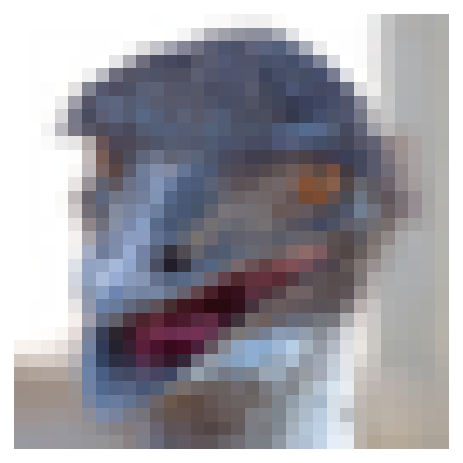

In [12]:
# Explore the dataset 
batch_id = 3
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [13]:
#data load & normalisation

In [14]:
# Put file path as a string here
CIFAR_DIR = 'cifar-10-batches-py/'

In [15]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [16]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [17]:
all_data = [0,1,2,3,4,5,6]

In [18]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [19]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [20]:
batch_meta #batch_meta[b"label_names"]

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [21]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [23]:
X = data_batch1[b"data"]

In [24]:
#Append X data
X = np.append(X,data_batch2[b"data"],axis=0)
X = np.append(X,data_batch3[b"data"],axis=0)
X = np.append(X,data_batch4[b"data"],axis=0)
X = np.append(X,data_batch5[b"data"],axis=0)

In [25]:
X.shape

(50000, 3072)

In [26]:
X_train = X.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [27]:
X_train.max()

255

In [28]:
#Normalize it for color
X_train=(X_train/255)

In [29]:
X_test = test_batch[b"data"]

In [30]:
X_test.shape

(10000, 3072)

In [31]:
X_test = X_test.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [32]:
X_test.max()

255

In [33]:
X_test=(X_test/255)

In [34]:
y = data_batch1[b"labels"]

In [35]:
#Append y values
y = np.append(y,data_batch2[b"labels"],axis=0)
y = np.append(y,data_batch3[b"labels"],axis=0)
y = np.append(y,data_batch4[b"labels"],axis=0)
y = np.append(y,data_batch5[b"labels"],axis=0)

In [36]:
y.shape

(50000,)

In [37]:
y[:3]

array([6, 9, 9])

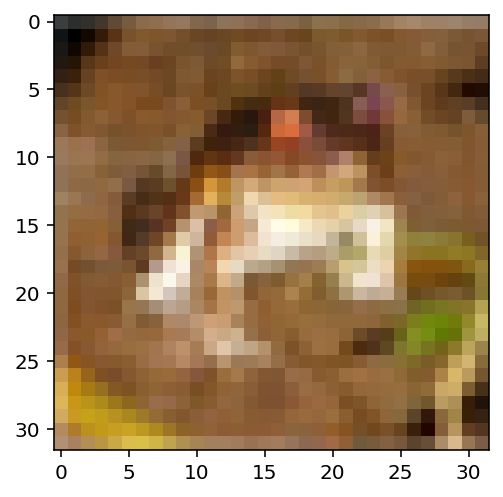

In [38]:
plt.imshow(X_train[0])

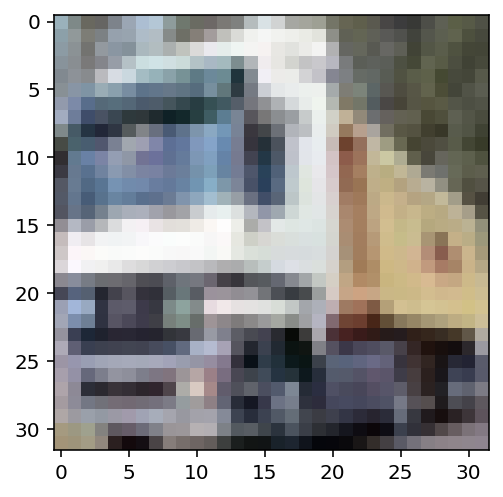

In [39]:
plt.imshow(X_train[1])

In [40]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [41]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [42]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [43]:
import tensorflow as tf
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [44]:
num_classes = 10
y_train = keras.utils.to_categorical(y, num_classes)

In [45]:
y_train[:1]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [46]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [47]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [53]:
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.3)

Train on 35000 samples, validate on 15000 samples
Epoch 1/3


23552/35000 [===================>..........] - ETA: 6:31 - loss: 2.3219 - accuracy: 0.05 - ETA: 4:04 - loss: 2.3170 - accuracy: 0.07 - ETA: 3:05 - loss: 2.3120 - accuracy: 0.08 - ETA: 2:37 - loss: 2.3097 - accuracy: 0.09 - ETA: 2:19 - loss: 2.3036 - accuracy: 0.10 - ETA: 2:07 - loss: 2.2958 - accuracy: 0.11 - ETA: 1:58 - loss: 2.2923 - accuracy: 0.12 - ETA: 1:53 - loss: 2.2916 - accuracy: 0.12 - ETA: 1:49 - loss: 2.2889 - accuracy: 0.12 - ETA: 1:45 - loss: 2.2917 - accuracy: 0.12 - ETA: 1:42 - loss: 2.2864 - accuracy: 0.12 - ETA: 1:39 - loss: 2.2822 - accuracy: 0.13 - ETA: 1:37 - loss: 2.2759 - accuracy: 0.13 - ETA: 1:35 - loss: 2.2740 - accuracy: 0.14 - ETA: 1:33 - loss: 2.2657 - accuracy: 0.14 - ETA: 1:31 - loss: 2.2591 - accuracy: 0.14 - ETA: 1:29 - loss: 2.2567 - accuracy: 0.14 - ETA: 1:28 - loss: 2.2527 - accuracy: 0.14 - ETA: 1:26 - loss: 2.2479 - accuracy: 0.15 - ETA: 1:25 - loss: 2.2424 - accuracy: 0.15 - ETA: 1:23 - loss: 2.2380 - accuracy: 0.15 - ETA: 1:22 - loss: 2.2355 - ac

35000/35000 [==============================] - ETA: 29s - loss: 1.8527 - accuracy: 0.322 - ETA: 29s - loss: 1.8518 - accuracy: 0.322 - ETA: 29s - loss: 1.8503 - accuracy: 0.323 - ETA: 28s - loss: 1.8495 - accuracy: 0.323 - ETA: 28s - loss: 1.8483 - accuracy: 0.324 - ETA: 28s - loss: 1.8468 - accuracy: 0.324 - ETA: 27s - loss: 1.8462 - accuracy: 0.324 - ETA: 27s - loss: 1.8444 - accuracy: 0.325 - ETA: 27s - loss: 1.8429 - accuracy: 0.326 - ETA: 26s - loss: 1.8415 - accuracy: 0.326 - ETA: 26s - loss: 1.8401 - accuracy: 0.327 - ETA: 26s - loss: 1.8390 - accuracy: 0.327 - ETA: 25s - loss: 1.8377 - accuracy: 0.327 - ETA: 25s - loss: 1.8360 - accuracy: 0.328 - ETA: 24s - loss: 1.8346 - accuracy: 0.328 - ETA: 24s - loss: 1.8333 - accuracy: 0.329 - ETA: 24s - loss: 1.8318 - accuracy: 0.329 - ETA: 23s - loss: 1.8304 - accuracy: 0.330 - ETA: 23s - loss: 1.8289 - accuracy: 0.330 - ETA: 23s - loss: 1.8274 - accuracy: 0.331 - ETA: 22s - loss: 1.8263 - accuracy: 0.332 - ETA: 22s - loss: 1.8248 - acc

23808/35000 [===================>..........] - ETA: 1:31 - loss: 1.4500 - accuracy: 0.46 - ETA: 1:29 - loss: 1.4893 - accuracy: 0.44 - ETA: 1:28 - loss: 1.4782 - accuracy: 0.47 - ETA: 1:27 - loss: 1.4476 - accuracy: 0.48 - ETA: 1:28 - loss: 1.4671 - accuracy: 0.46 - ETA: 1:28 - loss: 1.4242 - accuracy: 0.46 - ETA: 1:27 - loss: 1.4495 - accuracy: 0.46 - ETA: 1:26 - loss: 1.4687 - accuracy: 0.46 - ETA: 1:27 - loss: 1.4627 - accuracy: 0.46 - ETA: 1:26 - loss: 1.4492 - accuracy: 0.47 - ETA: 1:26 - loss: 1.4500 - accuracy: 0.47 - ETA: 1:25 - loss: 1.4444 - accuracy: 0.47 - ETA: 1:25 - loss: 1.4389 - accuracy: 0.48 - ETA: 1:25 - loss: 1.4432 - accuracy: 0.47 - ETA: 1:24 - loss: 1.4291 - accuracy: 0.47 - ETA: 1:24 - loss: 1.4349 - accuracy: 0.47 - ETA: 1:24 - loss: 1.4368 - accuracy: 0.48 - ETA: 1:23 - loss: 1.4396 - accuracy: 0.48 - ETA: 1:23 - loss: 1.4385 - accuracy: 0.48 - ETA: 1:23 - loss: 1.4384 - accuracy: 0.48 - ETA: 1:22 - loss: 1.4354 - accuracy: 0.48 - ETA: 1:22 - loss: 1.4353 - ac

35000/35000 [==============================] - ETA: 28s - loss: 1.3707 - accuracy: 0.506 - ETA: 28s - loss: 1.3708 - accuracy: 0.505 - ETA: 28s - loss: 1.3705 - accuracy: 0.506 - ETA: 27s - loss: 1.3703 - accuracy: 0.506 - ETA: 27s - loss: 1.3705 - accuracy: 0.505 - ETA: 27s - loss: 1.3694 - accuracy: 0.506 - ETA: 26s - loss: 1.3687 - accuracy: 0.506 - ETA: 26s - loss: 1.3674 - accuracy: 0.506 - ETA: 26s - loss: 1.3673 - accuracy: 0.506 - ETA: 25s - loss: 1.3667 - accuracy: 0.507 - ETA: 25s - loss: 1.3673 - accuracy: 0.506 - ETA: 25s - loss: 1.3671 - accuracy: 0.507 - ETA: 24s - loss: 1.3659 - accuracy: 0.507 - ETA: 24s - loss: 1.3654 - accuracy: 0.507 - ETA: 24s - loss: 1.3648 - accuracy: 0.507 - ETA: 23s - loss: 1.3637 - accuracy: 0.508 - ETA: 23s - loss: 1.3649 - accuracy: 0.507 - ETA: 23s - loss: 1.3639 - accuracy: 0.508 - ETA: 22s - loss: 1.3632 - accuracy: 0.508 - ETA: 22s - loss: 1.3627 - accuracy: 0.508 - ETA: 22s - loss: 1.3627 - accuracy: 0.508 - ETA: 21s - loss: 1.3619 - acc

23808/35000 [===================>..........] - ETA: 1:25 - loss: 1.2155 - accuracy: 0.58 - ETA: 1:25 - loss: 1.1642 - accuracy: 0.58 - ETA: 1:27 - loss: 1.2148 - accuracy: 0.56 - ETA: 1:27 - loss: 1.2144 - accuracy: 0.56 - ETA: 1:26 - loss: 1.1841 - accuracy: 0.57 - ETA: 1:26 - loss: 1.1919 - accuracy: 0.57 - ETA: 1:27 - loss: 1.1790 - accuracy: 0.57 - ETA: 1:26 - loss: 1.1928 - accuracy: 0.57 - ETA: 1:25 - loss: 1.1866 - accuracy: 0.57 - ETA: 1:25 - loss: 1.1858 - accuracy: 0.57 - ETA: 1:25 - loss: 1.2001 - accuracy: 0.57 - ETA: 1:24 - loss: 1.1953 - accuracy: 0.57 - ETA: 1:24 - loss: 1.2011 - accuracy: 0.57 - ETA: 1:24 - loss: 1.2120 - accuracy: 0.56 - ETA: 1:23 - loss: 1.2026 - accuracy: 0.57 - ETA: 1:23 - loss: 1.1955 - accuracy: 0.57 - ETA: 1:22 - loss: 1.2009 - accuracy: 0.57 - ETA: 1:22 - loss: 1.2093 - accuracy: 0.56 - ETA: 1:22 - loss: 1.2207 - accuracy: 0.56 - ETA: 1:22 - loss: 1.2183 - accuracy: 0.56 - ETA: 1:22 - loss: 1.2174 - accuracy: 0.56 - ETA: 1:22 - loss: 1.2165 - ac

35000/35000 [==============================] - ETA: 28s - loss: 1.2038 - accuracy: 0.576 - ETA: 28s - loss: 1.2041 - accuracy: 0.576 - ETA: 27s - loss: 1.2038 - accuracy: 0.576 - ETA: 27s - loss: 1.2041 - accuracy: 0.576 - ETA: 27s - loss: 1.2037 - accuracy: 0.576 - ETA: 26s - loss: 1.2028 - accuracy: 0.577 - ETA: 26s - loss: 1.2018 - accuracy: 0.577 - ETA: 26s - loss: 1.2019 - accuracy: 0.577 - ETA: 25s - loss: 1.2026 - accuracy: 0.577 - ETA: 25s - loss: 1.2025 - accuracy: 0.577 - ETA: 25s - loss: 1.2024 - accuracy: 0.577 - ETA: 24s - loss: 1.2020 - accuracy: 0.577 - ETA: 24s - loss: 1.2027 - accuracy: 0.577 - ETA: 24s - loss: 1.2024 - accuracy: 0.577 - ETA: 23s - loss: 1.2019 - accuracy: 0.577 - ETA: 23s - loss: 1.2016 - accuracy: 0.577 - ETA: 23s - loss: 1.2018 - accuracy: 0.577 - ETA: 22s - loss: 1.2017 - accuracy: 0.577 - ETA: 22s - loss: 1.2022 - accuracy: 0.576 - ETA: 22s - loss: 1.2025 - accuracy: 0.576 - ETA: 21s - loss: 1.2025 - accuracy: 0.576 - ETA: 21s - loss: 1.2023 - acc

In [54]:
model.save('ImageClass')

INFO:tensorflow:Assets written to: ImageClass\assets


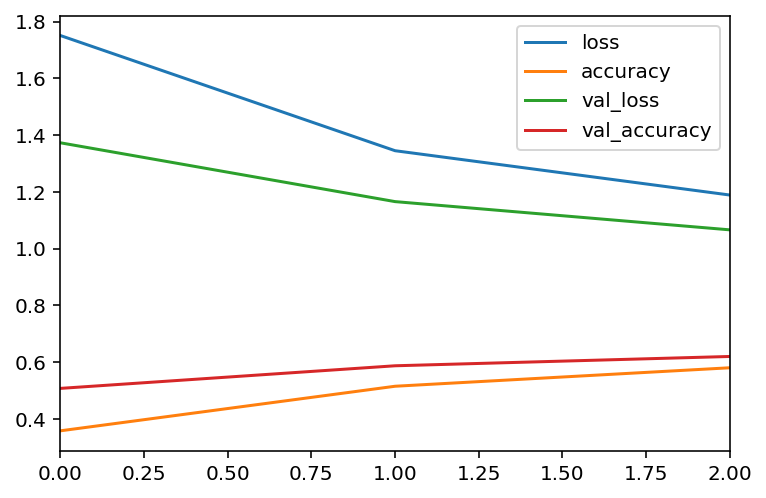

In [55]:
import pandas as pd
losses = pd.DataFrame(model.history.history)
losses.plot()

In [56]:
import tensorflow
new_model = tensorflow.keras.models.load_model('ImageClass')

In [57]:
#prediction

In [58]:
preds = new_model.predict(X_test)

In [59]:
batch_meta[b"label_names"][(np.argmax(preds[1]))]

b'ship'

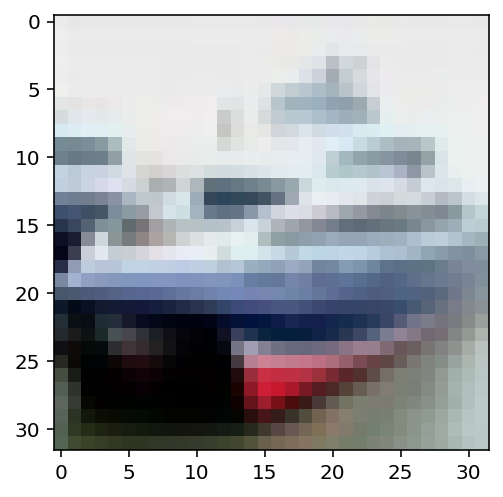

In [61]:
plt.imshow(X_test[1],cmap=plt.cm.binary)
plt.show()

In [62]:
batch_meta[b"label_names"][(np.argmax(preds[10]))]

b'airplane'

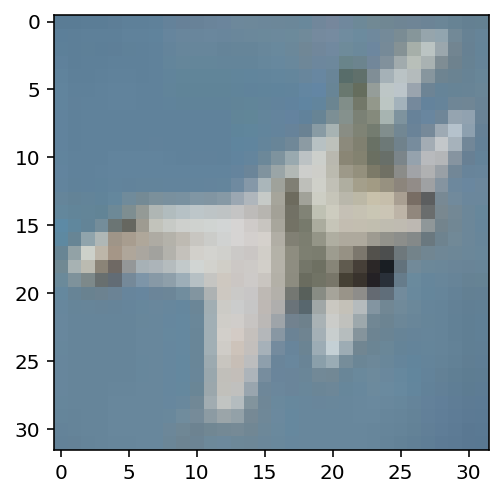

In [63]:
plt.imshow(X_test[10],cmap=plt.cm.binary)
plt.show()

# The End!